# Dataset Limpio

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.3 MB/s eta 0:00:00


Metodología y Estudio

Con el objetivo de maximizar el rendimiento del modelo, se ha diseñado una batería de pruebas comparativas para evaluar dos variables críticas:

1.  **Impacto del Data Augmentation:** Se analiza si la aplicación de técnicas de aumento de datos mejora la generalización o introduce ruido en el entrenamiento.
2.  **Estrategia para la clase 'Healthy' (Sana):** Se comparan dos enfoques de etiquetado:
    * **Clase Explícita:** Etiquetar las hojas sanas con bounding boxes (*Tomato Healthy*).
    * **Muestras Negativas:** Dejar las imágenes sanas sin etiquetas para que el modelo las interprete como fondo (*Background*).

## Dataset AUG

### Dataset Clase Healthy

In [ ]:
import os
import glob
import yaml

# 1. INSTALACIÓN Y DESCARGA (Tu código de Roboflow)
print("🤖 VcBot: Iniciando descarga desde Roboflow SDK...")

# Instalamos la librería (silenciosa para no llenar la pantalla)
# Tu código exacto
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="TrIRmN8b2RivP7N5Z1su")
project = rf.workspace("tomatoeswithhealthy").project("tomatoes-ddzvv-kx0gi-uulm1")
version = project.version(8)
dataset = version.download("yolov8")




# Capturamos la ruta donde Roboflow guardó los archivos
dataset_dir = dataset.location
print(f"\n✅ Descarga completada en: {dataset_dir}")

# ==========================================
# 2. REPORTE DE ESTRUCTURA Y CONTEO
# ==========================================
print(f"\n📊 REPORTE DEL DATASET (Carpeta: {dataset_dir})")
print("-" * 50)

carpetas = ['train', 'valid', 'test']
total_imgs = 0

for carpeta in carpetas:
    # Roboflow a veces usa 'valid', a veces 'val'. YOLO prefiere 'val' o 'valid'.
    # Buscamos la carpeta dentro de la ruta de descarga
    ruta_split = os.path.join(dataset_dir, carpeta)

    # Comprobamos si existe 'images' dentro
    ruta_imgs = os.path.join(ruta_split, 'images')
    if not os.path.exists(ruta_imgs):
        # A veces las imágenes están en la raíz del split
        ruta_imgs = ruta_split

    if os.path.exists(ruta_imgs) and os.path.isdir(ruta_imgs):
        imgs = glob.glob(os.path.join(ruta_imgs, '*.jpg')) + \
               glob.glob(os.path.join(ruta_imgs, '*.jpeg')) + \
               glob.glob(os.path.join(ruta_imgs, '*.png'))

        n = len(imgs)
        total_imgs += n
        print(f"📁 {carpeta.upper()}:")
        print(f"   └── {n} imágenes encontradas.")
    else:
        if carpeta != 'test': # Test es opcional
            print(f"⚠️ {carpeta.upper()}: No encontrada en {ruta_split}")

print("-" * 50)
print(f"∑ TOTAL: {total_imgs} imágenes.")

# ==========================================
# 3. ARREGLAR DATA.YAML (CRÍTICO PARA COLAB)
# ==========================================
print("\n🔧 CONFIGURACIÓN DE RUTAS (data.yaml)")

# Buscamos el yaml dentro de la carpeta descargada
yaml_path = os.path.join(dataset_dir, "data.yaml")

if os.path.exists(yaml_path):
    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        # 1. Ajustamos la ruta base absoluta
        data['path'] = os.path.abspath(dataset_dir)

        # 2. Ajustamos las relativas (Roboflow suele poner rutas absolutas que rompen Colab)
        data['train'] = "train/images"
        data['val'] = "valid/images" # Roboflow suele llamar a la validación 'valid'
        data['test'] = "test/images" # Si existe

        # 3. Guardamos
        with open(yaml_path, 'w') as f:
            yaml.dump(data, f, default_flow_style=False)

        print(f"   ✅ Archivo corregido: {yaml_path}")
        print("   (Rutas actualizadas para entrenamiento en Colab)")

        # Mostramos las clases detectadas
        if 'names' in data:
            print(f"   📋 Clases: {data['names']}")

    except Exception as e:
        print(f"   ❌ Error editando yaml: {e}")
else:
    print("   ❌ No se encontró 'data.yaml' dentro de la carpeta del dataset.")

print(f"\n🚀 LISTO. Para entrenar usa: data='{dataset_dir}/data.yaml'")

In [ ]:
import os
import glob
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import numpy as np
from collections import Counter

print("🤖 VcBot: Análisis Completo (Gráficas + Fotos Legibles)...")

# ==========================================
# 1. CARGAR CONFIGURACIÓN
# ==========================================
# Recuperar dataset_dir si se perdió
if 'dataset_dir' not in locals():
    import glob
    posibles = glob.glob("/content/tomatoes-*")
    if posibles: dataset_dir = sorted(posibles)[-1]
    else: dataset_dir = os.getcwd()

yaml_path = os.path.join(dataset_dir, "data.yaml")

class_names = []
if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
        names = data.get('names', [])
        # Normalizar nombres
        if isinstance(names, dict):
            class_names = [names[i] for i in sorted(names.keys())]
        else:
            class_names = names
else:
    print("❌ No encuentro data.yaml")

print(f"📋 Clases detectadas: {class_names}")

# ==========================================
# 2. GRÁFICAS Y CONTEO (Histograma)
# ==========================================
print("\n📊 Generando estadísticas y gráficas...")

label_files = glob.glob(f'{dataset_dir}/**/labels/*.txt', recursive=True)
class_counts = Counter()

for lfile in label_files:
    with open(lfile, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                try:
                    cls_id = int(parts[0])
                    if 0 <= cls_id < len(class_names):
                        class_counts[class_names[cls_id]] += 1
                except ValueError: pass

# --- AQUÍ ESTÁ EL GRÁFICO QUE PEDISTE ---
if class_counts:
    # 1. Tabla de texto
    print(f"\n{'CLASE':<30} | {'CANTIDAD':<10}")
    print("-" * 45)
    sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    for cls, count in sorted_items:
        print(f"{cls:<30} | {count:<10}")

    # 2. Gráfico de Barras (Seaborn)
    keys = [k for k, v in sorted_items]
    vals = [v for k, v in sorted_items]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=keys, y=vals, hue=keys, legend=False, palette="viridis")
    plt.title(f"Distribución de Etiquetas (Total: {sum(vals)})")
    plt.xlabel("Clase")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No se encontraron etiquetas para graficar.")

# ==========================================
# 3. VISUALIZACIÓN DE FOTOS (Mejorada)
# ==========================================
print("\n📸 Generando ejemplos visuales...")

all_images = glob.glob(f'{dataset_dir}/**/images/*.jpg', recursive=True) + \
             glob.glob(f'{dataset_dir}/**/images/*.png', recursive=True)

if all_images:
    samples = random.sample(all_images, min(len(all_images), 6))
    plt.figure(figsize=(15, 10))

    for i, img_path in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Buscar Label
        label_path = img_path.replace('/images/', '/labels/').rsplit('.', 1)[0] + ".txt"
        if not os.path.exists(label_path):
             label_path = os.path.join(os.path.dirname(os.path.dirname(img_path)), 'labels', os.path.basename(img_path).rsplit('.', 1)[0] + ".txt")

        box_drawn = False
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        try:
                            cls_id = int(parts[0])
                            # FIX: parts[1:5] para evitar error de unpack
                            cx, cy, bw, bh = map(float, parts[1:5])

                            x1 = int((cx - bw/2) * w)
                            y1 = int((cy - bh/2) * h)
                            x2 = int((cx + bw/2) * w)
                            y2 = int((cy + bh/2) * h)

                            color = plt.cm.tab10(cls_id % 10)
                            color_rgb = (int(color[0]*255), int(color[1]*255), int(color[2]*255))

                            # Dibujar caja
                            cv2.rectangle(img, (x1, y1), (x2, y2), color_rgb, 3)
                            box_drawn = True

                            # Texto inteligente
                            label_txt = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)

                            # Si está muy arriba, escribir abajo
                            text_y = y1 - 10 if y1 > 25 else y1 + 25

                            # Borde Negro + Texto Blanco
                            cv2.putText(img, label_txt, (x1, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 4)
                            cv2.putText(img, label_txt, (x1, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

                        except ValueError: pass

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis('off')

        # Título dinámico
        if box_drawn:
            plt.title(f"Detectado: {os.path.basename(img_path)[-10:]}")
        else:
            plt.title(f"Sana/Fondo: {os.path.basename(img_path)[-10:]}", color='green')

    plt.tight_layout()
    plt.show()
else:
    print("❌ No encontré imágenes.")

#### Ejecucion YOLO

In [ ]:
import gc
import torch
import os
import shutil
import yaml
from ultralytics import YOLO
from google.colab import drive

# ==============================================================================
# 1. PREPARACIÓN Y CONFIGURACIÓN
# ==============================================================================
print("🤖 VcBot: Iniciando configuración...")

# A. Montar Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# B. Definir ruta de salida en Drive (Para los resultados)
DRIVE_OUTPUT = "/content/drive/MyDrive/Torneo_Roboflow_Tomates_Healthy_AUG"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)


# D. Arreglar data.yaml
yaml_path = f"{dataset_dir}/data.yaml"

if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    data['path'] = os.path.abspath(dataset_dir)
    data['train'] = "train/images"
    data['val'] = "valid/images"
    data['test'] = "test/images"

    with open(yaml_path, 'w') as f:
        yaml.dump(data, f)
    print("🔧 data.yaml arreglado correctamente.")
else:
    # Esto es solo por seguridad si no ejecutas el bloque de descarga antes
    print("⚠️ ADVERTENCIA: No se encontró data.yaml. Asegúrate de haber descargado el dataset.")

    # Verificamos el contenido del archivo data.yaml
print(f"🧐 Inspeccionando archivo en: {dataset_dir}/data.yaml")
print("-" * 40)

with open(f"{dataset_dir}/data.yaml", 'r') as f:
    print(f.read())

print("-" * 40)

# ==============================================================================
# 2. ENTRENAMIENTO
# ==============================================================================
# Limpieza de memoria
gc.collect()
torch.cuda.empty_cache()

print("🚀 VcBot: Iniciando entrenamiento con YOLOv8-SMALL...")

model = YOLO('yolov8s.pt')

# Nombre del proyecto local
PROYECTO_LOCAL = 'entrenamiento_tomates_Healty_AUG'
NOMBRE_EJECUCION = 'yolov8s_detect'

try:
    model.train(
        data=f"{dataset_dir}/data.yaml",
        epochs=25,
        imgsz=640,
        batch=16,
        device=0 if torch.cuda.is_available() else 'cpu',
        project=PROYECTO_LOCAL,    # Carpeta raíz local
        name=NOMBRE_EJECUCION,     # Subcarpeta local
        patience=10,
        plots=True                 # ¡Importante! Genera los gráficos
    )
    print("✅ Entrenamiento finalizado correctamente.")

    # ==============================================================================
    # 3. GUARDAR SOLO RESULTADOS (SIN MODELOS PESADOS)
    # ==============================================================================
    print("\n📦 Empaquetando y guardando resultados en Drive...")

    # Ruta donde YOLO guardó todo en Colab
    origen_resultados = f"/content/{PROYECTO_LOCAL}/{NOMBRE_EJECUCION}"

    # Ruta destino en Drive
    destino_resultados = f"{DRIVE_OUTPUT}/{NOMBRE_EJECUCION}_Resultados"

    # Si ya existe la carpeta en Drive, la borramos para actualizarla
    if os.path.exists(destino_resultados):
        shutil.rmtree(destino_resultados)

    # COPIAR TODO EXCEPTO LA CARPETA 'weights'
    # Esto copiará: results.csv, confusion_matrix.png, results.png, etc.
    shutil.copytree(
        origen_resultados,
        destino_resultados,
        ignore=shutil.ignore_patterns('weights', '*.pt') # <--- AQUÍ ESTÁ LA MAGIA
    )

    print(f"🎉 ¡ÉXITO! Resultados guardados en: {destino_resultados}")
    print("   (Se han excluido los archivos .pt para ahorrar espacio, solo tienes gráficas y tablas)")

except Exception as e:
    print(f"❌ Error: {e}")

🤖 VcBot: Iniciando configuración...
Mounted at /content/drive
🔧 data.yaml arreglado correctamente.
🧐 Inspeccionando archivo en: /content/tomatoes-8/data.yaml
----------------------------------------
names:
- EarlyBlight
- Tomato healthy
- lateBlight
nc: 3
path: /content/tomatoes-8
roboflow:
  license: CC BY 4.0
  project: tomatoes-ddzvv-kx0gi-uulm1
  url: https://universe.roboflow.com/tomatoeswithhealthy/tomatoes-ddzvv-kx0gi-uulm1/dataset/8
  version: 8
  workspace: tomatoeswithhealthy
test: test/images
train: train/images
val: valid/images

----------------------------------------
🚀 VcBot: Iniciando entrenamiento con YOLOv8-SMALL...
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix

In [ ]:
import gc
import torch
import os
import shutil
import yaml
from ultralytics import YOLO
from google.colab import drive

# ==============================================================================
# 1. CONFIGURACIÓN DEL TORNEO
# ==============================================================================
print("🤖 VcBot: Preparando el cuadrilátero para el torneo...")

# A. Montar Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# B. Ruta base del torneo en Drive
DRIVE_BASE = "/content/drive/MyDrive/Torneo_YOLO_Tomates"
os.makedirs(DRIVE_BASE, exist_ok=True)

# C. Definir los contendientes (Modelos)
# Ajustamos el batch size: 'l' (large) consume mucha VRAM, así que bajamos a 8 o 4.
contendientes = [
    {"nombre": "yolov8s.pt",  "batch": 16},
    {"nombre": "yolov8m.pt",  "batch": 16},
    {"nombre": "yolov8l.pt",  "batch": 8},  # Batch reducido por seguridad
    {"nombre": "yolo11s.pt",  "batch": 16},
    {"nombre": "yolo11m.pt",  "batch": 16},
    {"nombre": "yolo11l.pt",  "batch": 8}   # Batch reducido por seguridad
]

# D. Asegurar data.yaml (usando tu variable dataset_dir)
# Asumimos que dataset_dir ya está definido por tu bloque de descarga anterior
if 'dataset_dir' in locals():
    yaml_path = f"{dataset_dir}/data.yaml"
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    data['path'] = os.path.abspath(dataset_dir)
    data['train'] = "train/images"
    data['val'] = "valid/images"
    data['test'] = "test/images"
    with open(yaml_path, 'w') as f:
        yaml.dump(data, f)
else:
    print("⚠️ ADVERTENCIA: Variable 'dataset_dir' no encontrada. Verifica la descarga.")

# ==============================================================================
# 2. BUCLE DE COMBATE (ENTRENAMIENTO)
# ==============================================================================

for i, luchador in enumerate(contendientes):
    modelo_archivo = luchador["nombre"]
    batch_size = luchador["batch"]
    nombre_combate = modelo_archivo.replace('.pt', '') # Ejemplo: yolov8s

    print("\n" + "="*60)
    print(f"🥊 RONDA {i+1}/{len(contendientes)}: Entrenando {nombre_combate} (Batch: {batch_size})")
    print("="*60)

    # 1. Limpieza de memoria (Fundamental en Colab)
    gc.collect()
    torch.cuda.empty_cache()

    try:
        # 2. Cargar modelo
        print(f"   ⏳ Cargando pesos: {modelo_archivo}...")
        model = YOLO(modelo_archivo)

        # 3. Entrenar
        # Usamos el mismo 'project' para que sea fácil comparar luego
        model.train(
            data=f"{dataset_dir}/data.yaml",
            epochs=25,                  # 25 épocas para el torneo
            imgsz=640,
            batch=batch_size,
            device=0 if torch.cuda.is_available() else 'cpu',
            project='Torneo_Local',     # Carpeta raíz en Colab
            name=nombre_combate,        # Subcarpeta (ej: yolov8s)
            patience=10,
            plots=True,
            verbose=True
        )
        print(f"   ✅ {nombre_combate} terminó el entrenamiento.")

        # 4. Guardar resultados en Drive
        print(f"   📦 Guardando estadísticas en Drive...")

        origen = f"/content/Torneo_Local/{nombre_combate}"
        destino = f"{DRIVE_BASE}/{nombre_combate}"

        if os.path.exists(destino):
            shutil.rmtree(destino)

        # Copiamos todo MENOS los pesos (.pt) para ahorrar espacio y tiempo
        # Si quieres guardar el mejor modelo, quita 'best.pt' de ignore_patterns
        shutil.copytree(
            origen,
            destino,
            ignore=shutil.ignore_patterns('weights', 'last.pt')
            # Nota: Si quieres guardar el modelo entrenado, borra 'weights' de arriba
        )
        print(f"   🎉 Resultados de {nombre_combate} guardados.")

    except Exception as e:
        print(f"   ❌ KO TÉCNICO: Error entrenando {nombre_combate}: {e}")
        # Intentamos seguir con el siguiente modelo aunque este falle
        continue

print("\n" + "="*60)
print("🏆 ¡TORNEO FINALIZADO!")
print(f"📂 Revisa los resultados y gráficas en Drive: {DRIVE_BASE}")
print("="*60)

### Dataset sin Clase Healthy

In [ ]:
import os
import glob
import yaml
from roboflow import Roboflow
from tqdm import tqdm


# ==========================================
# 2. CONFIGURACIÓN
# ==========================================
CLASE_A_BORRAR = "Tomato healthy"  # Esta clase dejará de tener cajas

# ==========================================
# 3. LÓGICA DE LIMPIEZA Y REMAPEO
# ==========================================
yaml_path = os.path.join(dataset_dir, "data.yaml")

with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)
    names = data['names'] # Lista de nombres

# A. Encontrar ID a borrar
if CLASE_A_BORRAR in names:
    id_borrar = names.index(CLASE_A_BORRAR)
    print(f"🎯 Clase '{CLASE_A_BORRAR}' encontrada con ID: {id_borrar}")
else:
    print(f"❌ La clase {CLASE_A_BORRAR} no existe. No se hará nada.")
    id_borrar = -999

if id_borrar != -999:
    # B. Crear mapa de nuevos IDs
    # (Si borramos la clase 7, la clase 8 pasa a ser la 7, la 9 a la 8, etc.)
    new_names = []
    id_map = {} # old_id -> new_id

    new_idx = 0
    for old_idx, name in enumerate(names):
        if old_idx == id_borrar:
            id_map[old_idx] = None # Marcamos para borrar
        else:
            id_map[old_idx] = new_idx
            new_names.append(name)
            new_idx += 1

    print(f"🔄 Re-mapeando {len(names)} clases a {len(new_names)} clases...")

    # C. Procesar todos los archivos .txt
    label_files = glob.glob(f"{dataset_dir}/**/labels/*.txt", recursive=True)

    files_modified = 0
    empty_files_created = 0 # Contaremos cuántas quedaron vacías (sanas)

    for lbl_file in tqdm(label_files):
        with open(lbl_file, 'r') as f:
            lines = f.readlines()

        new_lines = []
        is_modified = False

        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                old_id = int(parts[0])

                # Si es la clase sana -> SE IGNORA (no se añade a new_lines)
                if old_id == id_borrar:
                    is_modified = True
                    # Al no añadirla, la línea desaparece.
                    # Si todas las líneas eran de esta clase, el archivo queda vacío.

                # Si es otra enfermedad -> SE RE-MAPEA (se ajusta el ID)
                elif old_id in id_map:
                    new_id = id_map[old_id]
                    if new_id != old_id:
                        is_modified = True
                        new_line = f"{new_id} {' '.join(parts[1:])}\n"
                        new_lines.append(new_line)
                    else:
                        new_lines.append(line) # Se queda igual

        # Sobreescribimos el archivo solo si hubo cambios
        if is_modified:
            with open(lbl_file, 'w') as f:
                f.writelines(new_lines)
            files_modified += 1

        # Chequeo: ¿Quedó vacío?
        if len(new_lines) == 0:
            empty_files_created += 1

    # D. Actualizar data.yaml
    data['names'] = new_names
    data['nc'] = len(new_names)

    # Asegurar rutas absolutas para Colab
    data['path'] = os.path.abspath(dataset_dir)
    data['train'] = "train/images"
    data['val'] = "valid/images"
    data['test'] = "test/images"

    with open(yaml_path, 'w') as f:
        yaml.dump(data, f)

    print("\n" + "="*50)
    print("✅ PROCESO COMPLETADO")
    print(f"📉 Clases reducidas de {len(names)} a {len(new_names)}")
    print(f"🧹 Clase eliminada del listado: {CLASE_A_BORRAR}")
    print(f"📄 Archivos modificados: {files_modified}")
    print(f"🍃 Imágenes que ahora son 'Muestras Negativas' (sin caja): {empty_files_created}")
    print(f"🚀 Listo para entrenar con: data='{dataset_dir}/data.yaml'")
    print("="*50)

🎯 Clase 'Tomato healthy' encontrada con ID: 1
🔄 Re-mapeando 3 clases a 2 clases...


100%|██████████| 8230/8230 [00:00<00:00, 17743.41it/s]


✅ PROCESO COMPLETADO
📉 Clases reducidas de 3 a 2
🧹 Clase eliminada del listado: Tomato healthy
📄 Archivos modificados: 3931
🍃 Imágenes que ahora son 'Muestras Negativas' (sin caja): 614
🚀 Listo para entrenar con: data='/content/tomatoes-8/data.yaml'


🤖 VcBot: Verificando dataset modificado...
✅ Nuevas Clases (2): ['EarlyBlight', 'lateBlight']

📊 REPORTE POST-LIMPIEZA:
----------------------------------------
TIPO                           | CANTIDAD  
----------------------------------------
📦 EarlyBlight                  | 12626     
📦 lateBlight                   | 6421      
----------------------------------------
🍃 IMÁGENES SANAS (Sin Cajas)   | 614       
∑  TOTAL DE CAJAS (Etiquetas)  | 19047     
----------------------------------------

📸 Mostrando ejemplos (Incluyendo imágenes sanas/vacías)...


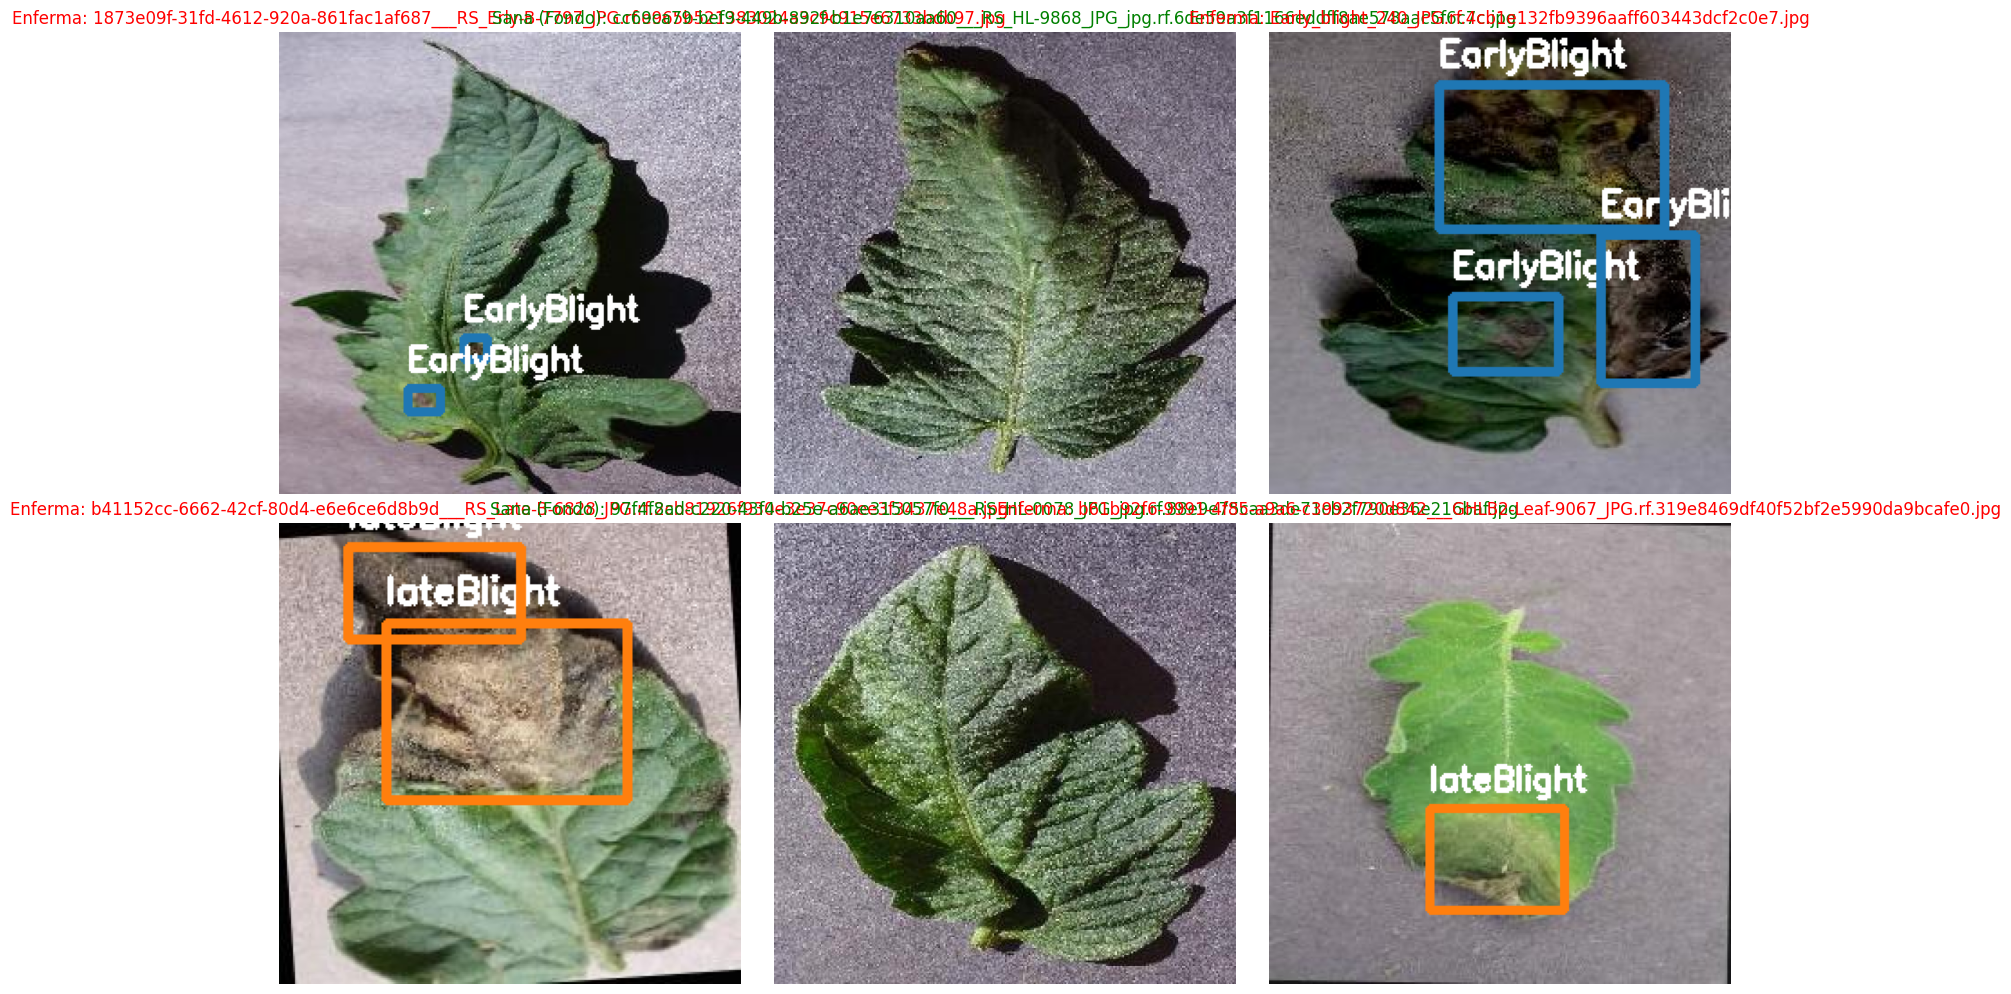

In [ ]:
import os
import glob
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from collections import Counter

print("🤖 VcBot: Verificando dataset modificado...")

# 1. CARGAR CONFIGURACIÓN
if 'dataset_dir' not in locals():
    # Si por alguna razón se perdió la variable, intenta definirla manualmente o busca
    # dataset_dir = "/content/tomatoes-..."
    print("⚠️ Variable dataset_dir no encontrada. Usando ruta actual.")
    dataset_dir = os.getcwd()

yaml_path = os.path.join(dataset_dir, "data.yaml")

with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)
    class_names = data.get('names', [])
    if isinstance(class_names, dict):
        class_names = [class_names[i] for i in sorted(class_names.keys())]

print(f"✅ Nuevas Clases ({len(class_names)}): {class_names}")

# 2. CONTEO DE OBJETOS Y FONDOS
label_files = glob.glob(f'{dataset_dir}/**/labels/*.txt', recursive=True)

class_counts = Counter()
empty_files = 0
total_boxes = 0

for lfile in label_files:
    # Verificamos si el archivo está vacío (0 bytes o sin líneas)
    if os.path.getsize(lfile) == 0:
        empty_files += 1
        continue

    with open(lfile, 'r') as f:
        lines = f.readlines()

    if not lines:
        empty_files += 1
        continue

    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            cls_id = int(parts[0])
            if 0 <= cls_id < len(class_names):
                class_counts[class_names[cls_id]] += 1
                total_boxes += 1

# 3. MOSTRAR RESULTADOS
print("\n📊 REPORTE POST-LIMPIEZA:")
print("-" * 40)
print(f"{'TIPO':<30} | {'CANTIDAD':<10}")
print("-" * 40)
for cls, count in class_counts.most_common():
    print(f"📦 {cls:<28} | {count:<10}")
print("-" * 40)
print(f"🍃 IMÁGENES SANAS (Sin Cajas)   | {empty_files:<10}")
print(f"∑  TOTAL DE CAJAS (Etiquetas)  | {total_boxes:<10}")
print("-" * 40)

# 4. VISUALIZACIÓN DE MUESTRAS
print("\n📸 Mostrando ejemplos (Incluyendo imágenes sanas/vacías)...")

all_images = glob.glob(f'{dataset_dir}/**/images/*.jpg', recursive=True) + \
             glob.glob(f'{dataset_dir}/**/images/*.png', recursive=True)

if all_images:
    # Tomamos una muestra aleatoria
    samples = random.sample(all_images, min(len(all_images), 6))

    plt.figure(figsize=(15, 10))

    for i, img_path in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Buscar label
        label_path = img_path.replace('/images/', '/labels/').rsplit('.', 1)[0] + ".txt"

        box_drawn = False
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls_id = int(parts[0])
                        cx, cy, bw, bh = map(float, parts[1:])

                        x1 = int((cx - bw/2) * w)
                        y1 = int((cy - bh/2) * h)
                        x2 = int((cx + bw/2) * w)
                        y2 = int((cy + bh/2) * h)

                        # Color
                        color = plt.cm.tab10(cls_id % 10)
                        color = (int(color[0]*255), int(color[1]*255), int(color[2]*255))

                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)

                        name = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
                        cv2.putText(img, name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
                        box_drawn = True

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis('off')

        if box_drawn:
            plt.title(f"Enferma: {os.path.basename(img_path)}", color='red')
        else:
            plt.title(f"Sana (Fondo): {os.path.basename(img_path)}", color='green')

    plt.tight_layout()
    plt.show()

#### Ejecucion YOLO

In [ ]:
import gc
import torch
import os
import shutil
from ultralytics import YOLO
from google.colab import drive

print("🚀 VcBot: Iniciando entrenamiento directo...")

# ==============================================================================
# 1. CONFIGURACIÓN DE DRIVE
# ==============================================================================
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

DRIVE_OUTPUT = "/content/drive/MyDrive/Torneo_Roboflow_Tomates_No_Healthy_AUG"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)

# ==============================================================================
# 2. ENTRENAMIENTO (YOLOv8 Small)
# ==============================================================================
# Limpieza preventiva de memoria
gc.collect()
torch.cuda.empty_cache()

# Por seguridad, si por algún motivo se borró la variable 'dataset_dir',
# intentamos reasignarla a la ruta que mostraste en tus logs (/content/tomatoes-4)
if 'dataset_dir' not in locals():
    if os.path.exists("/content/tomatoes-4"):
        dataset_dir = "/content/tomatoes-4"
    else:
        # Último recurso: buscar cualquier carpeta de tomates
        import glob
        posibles = glob.glob("/content/tomatoes-*")
        if posibles: dataset_dir = sorted(posibles)[-1]
        else: raise ValueError("❌ No encuentro la carpeta del dataset. Ejecuta la descarga de nuevo.")

print(f"📂 Entrenando con dataset en: {dataset_dir}")

model = YOLO('yolov8s.pt')

PROYECTO_LOCAL = 'entrenamiento_tomates_no_Healty_AUG'
NOMBRE_EJECUCION = 'yolov8s_detect'

try:
    model.train(
        data=f"{dataset_dir}/data.yaml",
        epochs=25,
        imgsz=640,
        batch=16,
        device=0 if torch.cuda.is_available() else 'cpu',
        project=PROYECTO_LOCAL,
        name=NOMBRE_EJECUCION,
        patience=10,
        plots=True,
        verbose=True
    )
    print("✅ Entrenamiento finalizado.")

    # ==============================================================================
    # 3. GUARDAR RESULTADOS EN DRIVE
    # ==============================================================================
    print("\n📦 Copiando gráficas a Drive...")

    origen = f"/content/{PROYECTO_LOCAL}/{NOMBRE_EJECUCION}"
    destino = f"{DRIVE_OUTPUT}/{NOMBRE_EJECUCION}_Resultados"

    if os.path.exists(destino):
        shutil.rmtree(destino)

    # Copiamos todo menos los pesos pesados (.pt)
    shutil.copytree(
        origen,
        destino,
        ignore=shutil.ignore_patterns('weights', '*.pt')
    )

    print(f"🎉 ¡ÉXITO! Resultados guardados en: {destino}")

except Exception as e:
    print(f"❌ Error en el entrenamiento: {e}")

🚀 VcBot: Iniciando entrenamiento directo...
📂 Entrenando con dataset en: /content/tomatoes-8
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/tomatoes-8/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_detect, nbs=64, nms=False,

## Dataset No Aug

###Dataset Clase Healthy

In [ ]:
import os
import glob
import yaml

# 1. INSTALACIÓN Y DESCARGA (Tu código de Roboflow)
print("🤖 VcBot: Iniciando descarga desde Roboflow SDK...")

# Tu código exacto
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="TrIRmN8b2RivP7N5Z1su")
project = rf.workspace("tomatoeswithhealthy").project("tomatoes-ddzvv-kx0gi-uulm1")
version = project.version(7)
dataset = version.download("yolov8")





# Capturamos la ruta donde Roboflow guardó los archivos
dataset_dir = dataset.location
print(f"\n✅ Descarga completada en: {dataset_dir}")

# ==========================================
# 2. REPORTE DE ESTRUCTURA Y CONTEO
# ==========================================
print(f"\n📊 REPORTE DEL DATASET (Carpeta: {dataset_dir})")
print("-" * 50)

carpetas = ['train', 'valid', 'test']
total_imgs = 0

for carpeta in carpetas:
    # Roboflow a veces usa 'valid', a veces 'val'. YOLO prefiere 'val' o 'valid'.
    # Buscamos la carpeta dentro de la ruta de descarga
    ruta_split = os.path.join(dataset_dir, carpeta)

    # Comprobamos si existe 'images' dentro
    ruta_imgs = os.path.join(ruta_split, 'images')
    if not os.path.exists(ruta_imgs):
        # A veces las imágenes están en la raíz del split
        ruta_imgs = ruta_split

    if os.path.exists(ruta_imgs) and os.path.isdir(ruta_imgs):
        imgs = glob.glob(os.path.join(ruta_imgs, '*.jpg')) + \
               glob.glob(os.path.join(ruta_imgs, '*.jpeg')) + \
               glob.glob(os.path.join(ruta_imgs, '*.png'))

        n = len(imgs)
        total_imgs += n
        print(f"📁 {carpeta.upper()}:")
        print(f"   └── {n} imágenes encontradas.")
    else:
        if carpeta != 'test': # Test es opcional
            print(f"⚠️ {carpeta.upper()}: No encontrada en {ruta_split}")

print("-" * 50)
print(f"∑ TOTAL: {total_imgs} imágenes.")

# ==========================================
# 3. ARREGLAR DATA.YAML (CRÍTICO PARA COLAB)
# ==========================================
print("\n🔧 CONFIGURACIÓN DE RUTAS (data.yaml)")

# Buscamos el yaml dentro de la carpeta descargada
yaml_path = os.path.join(dataset_dir, "data.yaml")

if os.path.exists(yaml_path):
    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        # 1. Ajustamos la ruta base absoluta
        data['path'] = os.path.abspath(dataset_dir)

        # 2. Ajustamos las relativas (Roboflow suele poner rutas absolutas que rompen Colab)
        data['train'] = "train/images"
        data['val'] = "valid/images" # Roboflow suele llamar a la validación 'valid'
        data['test'] = "test/images" # Si existe

        # 3. Guardamos
        with open(yaml_path, 'w') as f:
            yaml.dump(data, f, default_flow_style=False)

        print(f"   ✅ Archivo corregido: {yaml_path}")
        print("   (Rutas actualizadas para entrenamiento en Colab)")

        # Mostramos las clases detectadas
        if 'names' in data:
            print(f"   📋 Clases: {data['names']}")

    except Exception as e:
        print(f"   ❌ Error editando yaml: {e}")
else:
    print("   ❌ No se encontró 'data.yaml' dentro de la carpeta del dataset.")

print(f"\n🚀 LISTO. Para entrenar usa: data='{dataset_dir}/data.yaml'")

🤖 VcBot: Iniciando descarga desde Roboflow SDK...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 54.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to tomatoes-7 in yolov8:: 100%|██████████| 7308/7308 [00:00<00:00, 10290.60it/s]



✅ Descarga completada en: /content/tomatoes-7

📊 REPORTE DEL DATASET (Carpeta: /content/tomatoes-7)
--------------------------------------------------
📁 TRAIN:
   └── 2395 imágenes encontradas.
📁 VALID:
   └── 701 imágenes encontradas.
📁 TEST:
   └── 552 imágenes encontradas.
--------------------------------------------------
∑ TOTAL: 3648 imágenes.

🔧 CONFIGURACIÓN DE RUTAS (data.yaml)
   ✅ Archivo corregido: /content/tomatoes-7/data.yaml
   (Rutas actualizadas para entrenamiento en Colab)
   📋 Clases: ['EarlyBlight', 'Tomato healthy', 'lateBlight']

🚀 LISTO. Para entrenar usa: data='/content/tomatoes-7/data.yaml'


🤖 VcBot: Iniciando análisis forense del dataset descargado...
✅ Archivo de configuración cargado: /content/tomatoes-7/data.yaml
📋 Clases detectadas (3): ['EarlyBlight', 'Tomato healthy', 'lateBlight']

⏳ Contando objetos en las etiquetas...

📊 RECUENTO DE OBJETOS:
CLASE                          | CANTIDAD  
---------------------------------------------
EarlyBlight                    | 5290      
lateBlight                     | 3055      
Tomato healthy                 | 306       


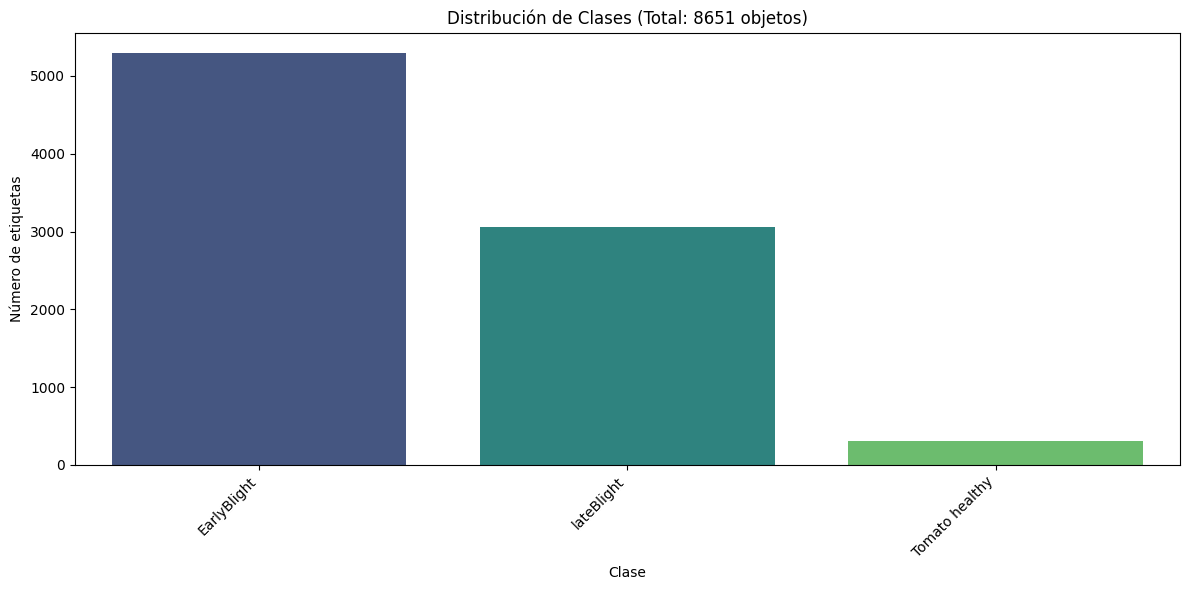


📸 Mostrando ejemplos visuales aleatorios...


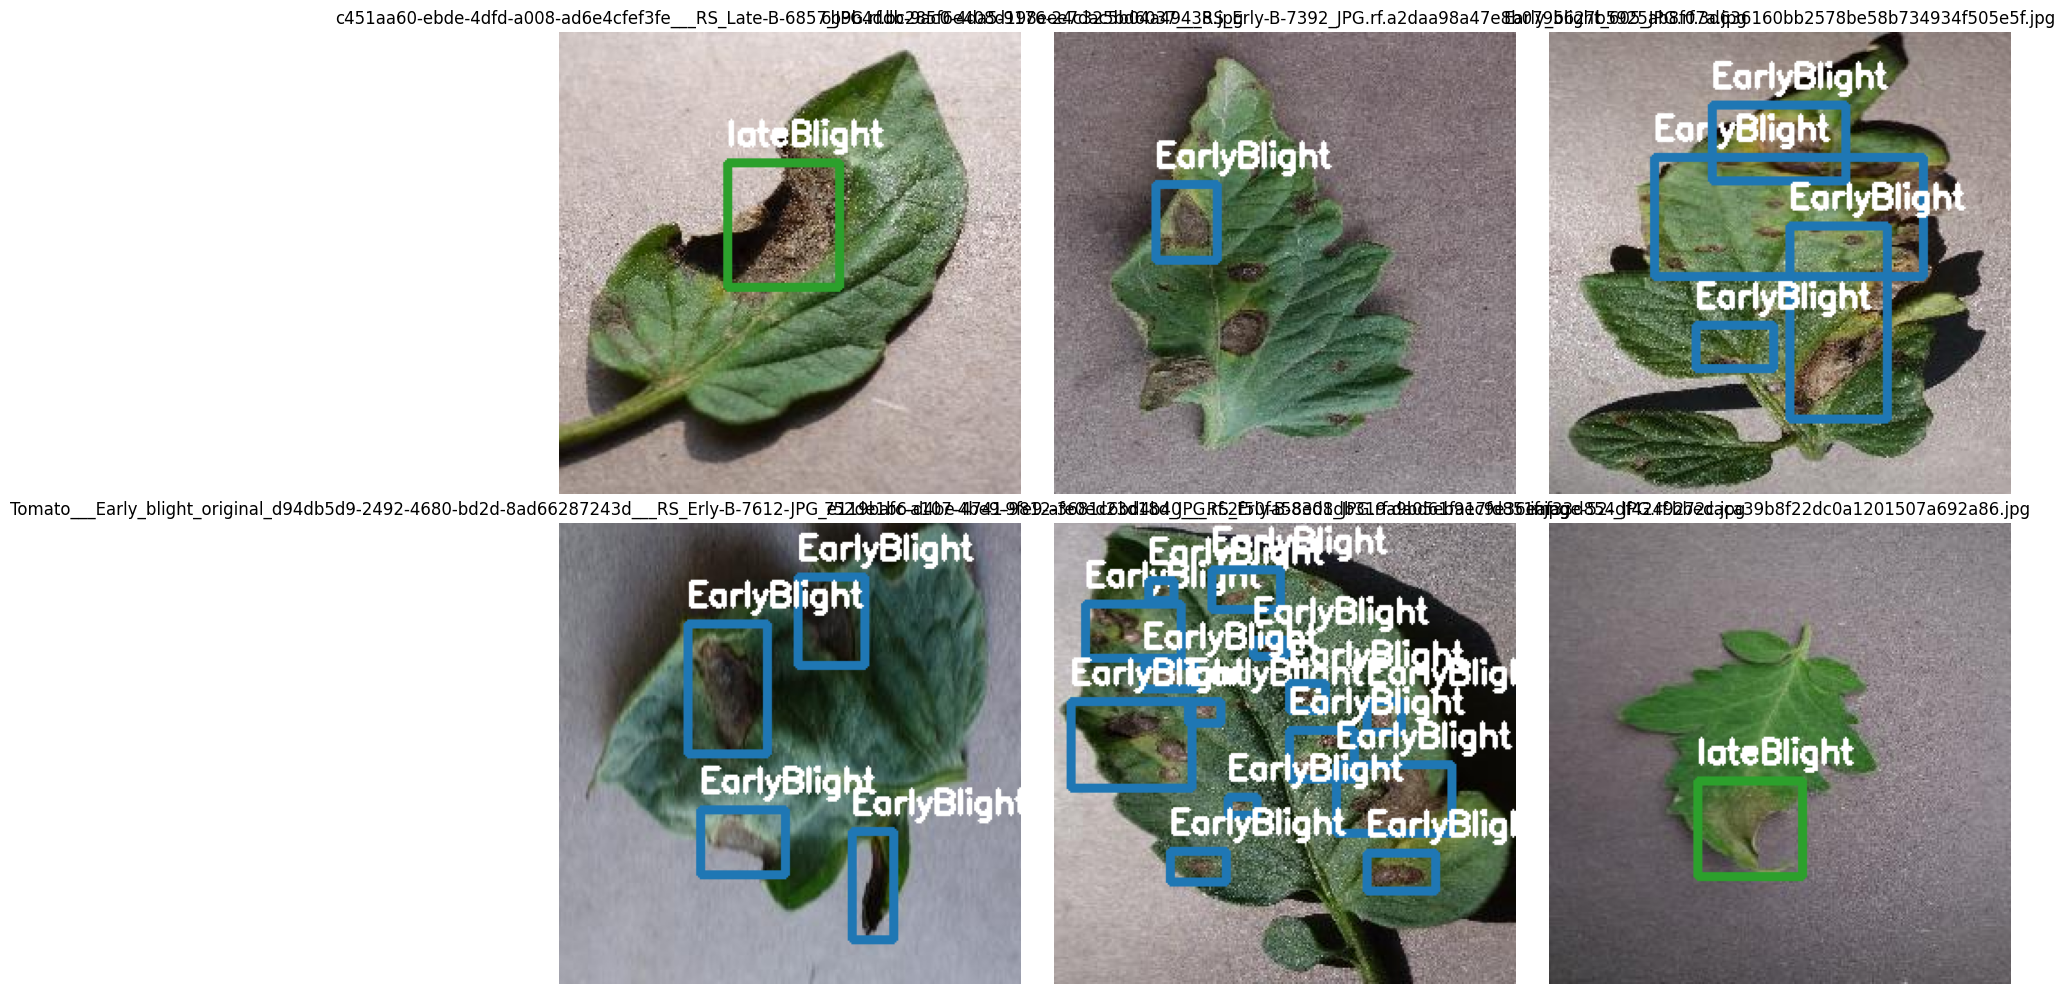

In [ ]:
import os
import glob
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import numpy as np
from collections import Counter

print("🤖 VcBot: Iniciando análisis forense del dataset descargado...")

# ==========================================
# 1. CARGAR CONFIGURACIÓN (Usando dataset_dir)
# ==========================================
# Asumimos que dataset_dir viene del bloque anterior
if 'dataset_dir' not in locals():
    print("❌ ERROR: La variable 'dataset_dir' no está definida. Ejecuta el bloque de descarga primero.")
else:
    target_yaml = os.path.join(dataset_dir, "data.yaml")

    if not os.path.exists(target_yaml):
        print(f"❌ ERROR: No encuentro el archivo data.yaml en {dataset_dir}")
    else:
        print(f"✅ Archivo de configuración cargado: {target_yaml}")

        with open(target_yaml, 'r') as f:
            data = yaml.safe_load(f)

        # Obtener nombres de las clases
        class_names = data.get('names', [])

        # Normalizar si viene como diccionario {0: 'tomate', 1: 'manzana'}
        if isinstance(class_names, dict):
            class_names = [class_names[i] for i in sorted(class_names.keys())]

        print(f"📋 Clases detectadas ({len(class_names)}): {class_names}")

        # ==========================================
        # 2. CONTAR INSTANCIAS POR CLASE
        # ==========================================
        print("\n⏳ Contando objetos en las etiquetas...")

        class_counts = Counter()

        # Buscamos etiquetas recursivamente dentro de dataset_dir
        label_files = glob.glob(f'{dataset_dir}/**/labels/*.txt', recursive=True)

        for lfile in label_files:
            with open(lfile, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        try:
                            class_id = int(parts[0])
                            if 0 <= class_id < len(class_names):
                                class_counts[class_names[class_id]] += 1
                        except ValueError:
                            pass # Ignorar líneas mal formadas

        # Mostrar tabla de texto
        print("\n📊 RECUENTO DE OBJETOS:")
        print(f"{'CLASE':<30} | {'CANTIDAD':<10}")
        print("-" * 45)

        if class_counts:
            for cls, count in class_counts.most_common():
                print(f"{cls:<30} | {count:<10}")

            #
            # Generar Gráfico (Histograma)
            plt.figure(figsize=(12, 6))
            sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
            keys = [k for k, v in sorted_items]
            vals = [v for k, v in sorted_items]

            sns.barplot(x=keys, y=vals, hue=keys, legend=False, palette="viridis")
            plt.title(f"Distribución de Clases (Total: {sum(vals)} objetos)")
            plt.xlabel("Clase")
            plt.ylabel("Número de etiquetas")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ No se encontraron objetos etiquetados. Revisa si las etiquetas están vacías.")

        # ==========================================
        # 3. VISUALIZACIÓN DE IMÁGENES CON CAJAS
        # ==========================================
        print("\n📸 Mostrando ejemplos visuales aleatorios...")

        # Buscamos imágenes en el directorio correcto
        all_images = glob.glob(f'{dataset_dir}/**/images/*.jpg', recursive=True) + \
                     glob.glob(f'{dataset_dir}/**/images/*.jpeg', recursive=True) + \
                     glob.glob(f'{dataset_dir}/**/images/*.png', recursive=True)

        if all_images:
            num_samples = 6
            samples = random.sample(all_images, min(len(all_images), num_samples))

            plt.figure(figsize=(15, 10))

            for i, img_path in enumerate(samples):
                img = cv2.imread(img_path)
                if img is None: continue

                # Convertir BGR a RGB para matplotlib
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                h, w, _ = img.shape

                # Buscar etiqueta correspondiente (misma carpeta pero en 'labels')
                # Estrategia robusta: reemplazar 'images' por 'labels' en la ruta
                label_path = img_path.replace('/images/', '/labels/')
                label_path = os.path.splitext(label_path)[0] + ".txt"

                # Si la estructura es distinta (ej: root/images vs root/labels), intentar buscar
                if not os.path.exists(label_path):
                    # Intento alternativo simple
                    dirname = os.path.dirname(img_path)
                    if dirname.endswith('images'):
                        label_dir = os.path.join(os.path.dirname(dirname), 'labels')
                        fname = os.path.splitext(os.path.basename(img_path))[0] + ".txt"
                        label_path = os.path.join(label_dir, fname)

                if os.path.exists(label_path):
                    with open(label_path, 'r') as f:
                        for line in f.readlines():
                            parts = line.strip().split()
                            if len(parts) >= 5:
                                cls_id = int(parts[0])
                                cx, cy, bw, bh = map(float, parts[1:])

                                # Coordenadas pixel (YOLO format: center_x, center_y, width, height)
                                x1 = int((cx - bw/2) * w)
                                y1 = int((cy - bh/2) * h)
                                x2 = int((cx + bw/2) * w)
                                y2 = int((cy + bh/2) * h)

                                # Color dinámico según ID
                                color_idx = cls_id % 10
                                color = plt.cm.tab10(color_idx)
                                color_rgb = (int(color[0]*255), int(color[1]*255), int(color[2]*255))

                                cv2.rectangle(img, (x1, y1), (x2, y2), color_rgb, 3)

                                label_text = class_names[cls_id] if 0 <= cls_id < len(class_names) else str(cls_id)
                                cv2.putText(img, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

                #
                plt.subplot(2, 3, i+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(os.path.basename(img_path))

            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ No encontré imágenes para mostrar en las rutas esperadas.")

#### Ejecucion YOLO

In [ ]:
import gc
import torch
import os
import shutil
import yaml
from ultralytics import YOLO
from google.colab import drive

# ==============================================================================
# 1. PREPARACIÓN Y CONFIGURACIÓN
# ==============================================================================
print("🤖 VcBot: Iniciando configuración...")

# A. Montar Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# B. Definir ruta de salida en Drive (Para los resultados)
DRIVE_OUTPUT = "/content/drive/MyDrive/Torneo_Roboflow_Tomates_Healthy"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)


# D. Arreglar data.yaml
yaml_path = f"{dataset_dir}/data.yaml"

if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    data['path'] = os.path.abspath(dataset_dir)
    data['train'] = "train/images"
    data['val'] = "valid/images"
    data['test'] = "test/images"

    with open(yaml_path, 'w') as f:
        yaml.dump(data, f)
    print("🔧 data.yaml arreglado correctamente.")
else:
    # Esto es solo por seguridad si no ejecutas el bloque de descarga antes
    print("⚠️ ADVERTENCIA: No se encontró data.yaml. Asegúrate de haber descargado el dataset.")

# ==============================================================================
# 2. ENTRENAMIENTO
# ==============================================================================
# Limpieza de memoria
gc.collect()
torch.cuda.empty_cache()

print("🚀 VcBot: Iniciando entrenamiento con YOLOv8-SMALL...")

model = YOLO('yolov8s.pt')

# Nombre del proyecto local
PROYECTO_LOCAL = 'entrenamiento_tomates_Healty'
NOMBRE_EJECUCION = 'yolov8s_detect'

try:
    model.train(
        data=f"{dataset_dir}/data.yaml",
        epochs=25,
        imgsz=640,
        batch=16,
        device=0 if torch.cuda.is_available() else 'cpu',
        project=PROYECTO_LOCAL,    # Carpeta raíz local
        name=NOMBRE_EJECUCION,     # Subcarpeta local
        patience=10,
        plots=True                 # ¡Importante! Genera los gráficos
    )
    print("✅ Entrenamiento finalizado correctamente.")

    # ==============================================================================
    # 3. GUARDAR SOLO RESULTADOS (SIN MODELOS PESADOS)
    # ==============================================================================
    print("\n📦 Empaquetando y guardando resultados en Drive...")

    # Ruta donde YOLO guardó todo en Colab
    origen_resultados = f"/content/{PROYECTO_LOCAL}/{NOMBRE_EJECUCION}"

    # Ruta destino en Drive
    destino_resultados = f"{DRIVE_OUTPUT}/{NOMBRE_EJECUCION}_Resultados"

    # Si ya existe la carpeta en Drive, la borramos para actualizarla
    if os.path.exists(destino_resultados):
        shutil.rmtree(destino_resultados)

    # COPIAR TODO EXCEPTO LA CARPETA 'weights'
    # Esto copiará: results.csv, confusion_matrix.png, results.png, etc.
    shutil.copytree(
        origen_resultados,
        destino_resultados,
        ignore=shutil.ignore_patterns('weights', '*.pt') # <--- AQUÍ ESTÁ LA MAGIA
    )

    print(f"🎉 ¡ÉXITO! Resultados guardados en: {destino_resultados}")
    print("   (Se han excluido los archivos .pt para ahorrar espacio, solo tienes gráficas y tablas)")

except Exception as e:
    print(f"❌ Error: {e}")

🤖 VcBot: Iniciando configuración...
🔧 data.yaml arreglado correctamente.
🚀 VcBot: Iniciando entrenamiento con YOLOv8-SMALL...
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/tomatoes-7/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=y

<font color = "blue"> Organizo un torneo para ver que modelo se ajusta mejor, ya que al hacer mis pruebas el dataset sin data Augmentation y con clase Healthy ha ganado

In [ ]:
import gc
import torch
import os
import shutil
import yaml
from ultralytics import YOLO
from google.colab import drive

# ==============================================================================
# 1. CONFIGURACIÓN DEL TORNEO
# ==============================================================================
print("🤖 VcBot: Preparando el cuadrilátero para el torneo...")

# A. Montar Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# B. Ruta base del torneo en Drive
DRIVE_BASE = "/content/drive/MyDrive/Torneo_YOLO_Tomates"
os.makedirs(DRIVE_BASE, exist_ok=True)

# C. Definir los contendientes (Modelos)
# Ajustamos el batch size: 'l' (large) consume mucha VRAM, así que bajamos a 8 o 4.
contendientes = [
    {"nombre": "yolov8s.pt",  "batch": 16},
    {"nombre": "yolov8m.pt",  "batch": 16},
    {"nombre": "yolov8l.pt",  "batch": 8},  # Batch reducido por seguridad
    {"nombre": "yolo11s.pt",  "batch": 16},
    {"nombre": "yolo11m.pt",  "batch": 16},
    {"nombre": "yolo11l.pt",  "batch": 8}   # Batch reducido por seguridad
]

# D. Asegurar data.yaml (usando tu variable dataset_dir)
# Asumimos que dataset_dir ya está definido por tu bloque de descarga anterior
if 'dataset_dir' in locals():
    yaml_path = f"{dataset_dir}/data.yaml"
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    data['path'] = os.path.abspath(dataset_dir)
    data['train'] = "train/images"
    data['val'] = "valid/images"
    data['test'] = "test/images"
    with open(yaml_path, 'w') as f:
        yaml.dump(data, f)
else:
    print("⚠️ ADVERTENCIA: Variable 'dataset_dir' no encontrada. Verifica la descarga.")

# ==============================================================================
# 2. BUCLE DE COMBATE (ENTRENAMIENTO)
# ==============================================================================

for i, luchador in enumerate(contendientes):
    modelo_archivo = luchador["nombre"]
    batch_size = luchador["batch"]
    nombre_combate = modelo_archivo.replace('.pt', '') # Ejemplo: yolov8s

    print("\n" + "="*60)
    print(f"🥊 RONDA {i+1}/{len(contendientes)}: Entrenando {nombre_combate} (Batch: {batch_size})")
    print("="*60)

    # 1. Limpieza de memoria (Fundamental en Colab)
    gc.collect()
    torch.cuda.empty_cache()

    try:
        # 2. Cargar modelo
        print(f"   ⏳ Cargando pesos: {modelo_archivo}...")
        model = YOLO(modelo_archivo)

        # 3. Entrenar
        # Usamos el mismo 'project' para que sea fácil comparar luego
        model.train(
            data=f"{dataset_dir}/data.yaml",
            epochs=25,                  # 25 épocas para el torneo
            imgsz=640,
            batch=batch_size,
            device=0 if torch.cuda.is_available() else 'cpu',
            project='Torneo_Local',     # Carpeta raíz en Colab
            name=nombre_combate,        # Subcarpeta (ej: yolov8s)
            patience=10,
            plots=True,
            verbose=True
        )
        print(f"   ✅ {nombre_combate} terminó el entrenamiento.")

        # 4. Guardar resultados en Drive
        print(f"   📦 Guardando estadísticas en Drive...")

        origen = f"/content/Torneo_Local/{nombre_combate}"
        destino = f"{DRIVE_BASE}/{nombre_combate}"

        if os.path.exists(destino):
            shutil.rmtree(destino)

        # Copiamos todo MENOS los pesos (.pt) para ahorrar espacio y tiempo
        # Si quieres guardar el mejor modelo, quita 'best.pt' de ignore_patterns
        shutil.copytree(
            origen,
            destino,
            ignore=shutil.ignore_patterns('weights', 'last.pt')
            # Nota: Si quieres guardar el modelo entrenado, borra 'weights' de arriba
        )
        print(f"   🎉 Resultados de {nombre_combate} guardados.")

    except Exception as e:
        print(f"   ❌ KO TÉCNICO: Error entrenando {nombre_combate}: {e}")
        # Intentamos seguir con el siguiente modelo aunque este falle
        continue

print("\n" + "="*60)
print("🏆 ¡TORNEO FINALIZADO!")
print(f"📂 Revisa los resultados y gráficas en Drive: {DRIVE_BASE}")
print("="*60)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🤖 VcBot: Preparando el cuadrilátero para el torneo...
Mounted at /content/drive

🥊 RONDA 1/6: Entrenando yolov8s (Batch: 16)
   ⏳ Cargando pesos: yolov8s.pt...
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/tomatoes-7/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, ex

### Dataset Sin Clase Healthy

In [ ]:
import os
import glob
import yaml
from roboflow import Roboflow
from tqdm import tqdm



dataset_dir = dataset.location
# ==========================================
# 2. CONFIGURACIÓN
# ==========================================
CLASE_A_BORRAR = "Tomato healthy"  # Esta clase dejará de tener cajas

# ==========================================
# 3. LÓGICA DE LIMPIEZA Y REMAPEO
# ==========================================
yaml_path = os.path.join(dataset_dir, "data.yaml")

with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)
    names = data['names'] # Lista de nombres

# A. Encontrar ID a borrar
if CLASE_A_BORRAR in names:
    id_borrar = names.index(CLASE_A_BORRAR)
    print(f"🎯 Clase '{CLASE_A_BORRAR}' encontrada con ID: {id_borrar}")
else:
    print(f"❌ La clase {CLASE_A_BORRAR} no existe. No se hará nada.")
    id_borrar = -999

if id_borrar != -999:
    # B. Crear mapa de nuevos IDs
    # (Si borramos la clase 7, la clase 8 pasa a ser la 7, la 9 a la 8, etc.)
    new_names = []
    id_map = {} # old_id -> new_id

    new_idx = 0
    for old_idx, name in enumerate(names):
        if old_idx == id_borrar:
            id_map[old_idx] = None # Marcamos para borrar
        else:
            id_map[old_idx] = new_idx
            new_names.append(name)
            new_idx += 1

    print(f"🔄 Re-mapeando {len(names)} clases a {len(new_names)} clases...")

    # C. Procesar todos los archivos .txt
    label_files = glob.glob(f"{dataset_dir}/**/labels/*.txt", recursive=True)

    files_modified = 0
    empty_files_created = 0 # Contaremos cuántas quedaron vacías (sanas)

    for lbl_file in tqdm(label_files):
        with open(lbl_file, 'r') as f:
            lines = f.readlines()

        new_lines = []
        is_modified = False

        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                old_id = int(parts[0])

                # Si es la clase sana -> SE IGNORA (no se añade a new_lines)
                if old_id == id_borrar:
                    is_modified = True
                    # Al no añadirla, la línea desaparece.
                    # Si todas las líneas eran de esta clase, el archivo queda vacío.

                # Si es otra enfermedad -> SE RE-MAPEA (se ajusta el ID)
                elif old_id in id_map:
                    new_id = id_map[old_id]
                    if new_id != old_id:
                        is_modified = True
                        new_line = f"{new_id} {' '.join(parts[1:])}\n"
                        new_lines.append(new_line)
                    else:
                        new_lines.append(line) # Se queda igual

        # Sobreescribimos el archivo solo si hubo cambios
        if is_modified:
            with open(lbl_file, 'w') as f:
                f.writelines(new_lines)
            files_modified += 1

        # Chequeo: ¿Quedó vacío?
        if len(new_lines) == 0:
            empty_files_created += 1

    # D. Actualizar data.yaml
    data['names'] = new_names
    data['nc'] = len(new_names)

    # Asegurar rutas absolutas para Colab
    data['path'] = os.path.abspath(dataset_dir)
    data['train'] = "train/images"
    data['val'] = "valid/images"
    data['test'] = "test/images"

    with open(yaml_path, 'w') as f:
        yaml.dump(data, f)

    print("\n" + "="*50)
    print("✅ PROCESO COMPLETADO")
    print(f"📉 Clases reducidas de {len(names)} a {len(new_names)}")
    print(f"🧹 Clase eliminada del listado: {CLASE_A_BORRAR}")
    print(f"📄 Archivos modificados: {files_modified}")
    print(f"🍃 Imágenes que ahora son 'Muestras Negativas' (sin caja): {empty_files_created}")
    print(f"🚀 Listo para entrenar con: data='{dataset_dir}/data.yaml'")
    print("="*50)

🎯 Clase 'Tomato healthy' encontrada con ID: 1
🔄 Re-mapeando 3 clases a 2 clases...


100%|██████████| 3648/3648 [00:00<00:00, 19782.51it/s]


✅ PROCESO COMPLETADO
📉 Clases reducidas de 3 a 2
🧹 Clase eliminada del listado: Tomato healthy
📄 Archivos modificados: 1857
🍃 Imágenes que ahora son 'Muestras Negativas' (sin caja): 306
🚀 Listo para entrenar con: data='/content/tomatoes-7/data.yaml'


🤖 VcBot: Verificando dataset modificado...
✅ Nuevas Clases (2): ['EarlyBlight', 'lateBlight']

📊 REPORTE POST-LIMPIEZA:
----------------------------------------
TIPO                           | CANTIDAD  
----------------------------------------
📦 EarlyBlight                  | 5290      
📦 lateBlight                   | 3055      
----------------------------------------
🍃 IMÁGENES SANAS (Sin Cajas)   | 306       
∑  TOTAL DE CAJAS (Etiquetas)  | 8345      
----------------------------------------

📸 Mostrando ejemplos (Incluyendo imágenes sanas/vacías)...


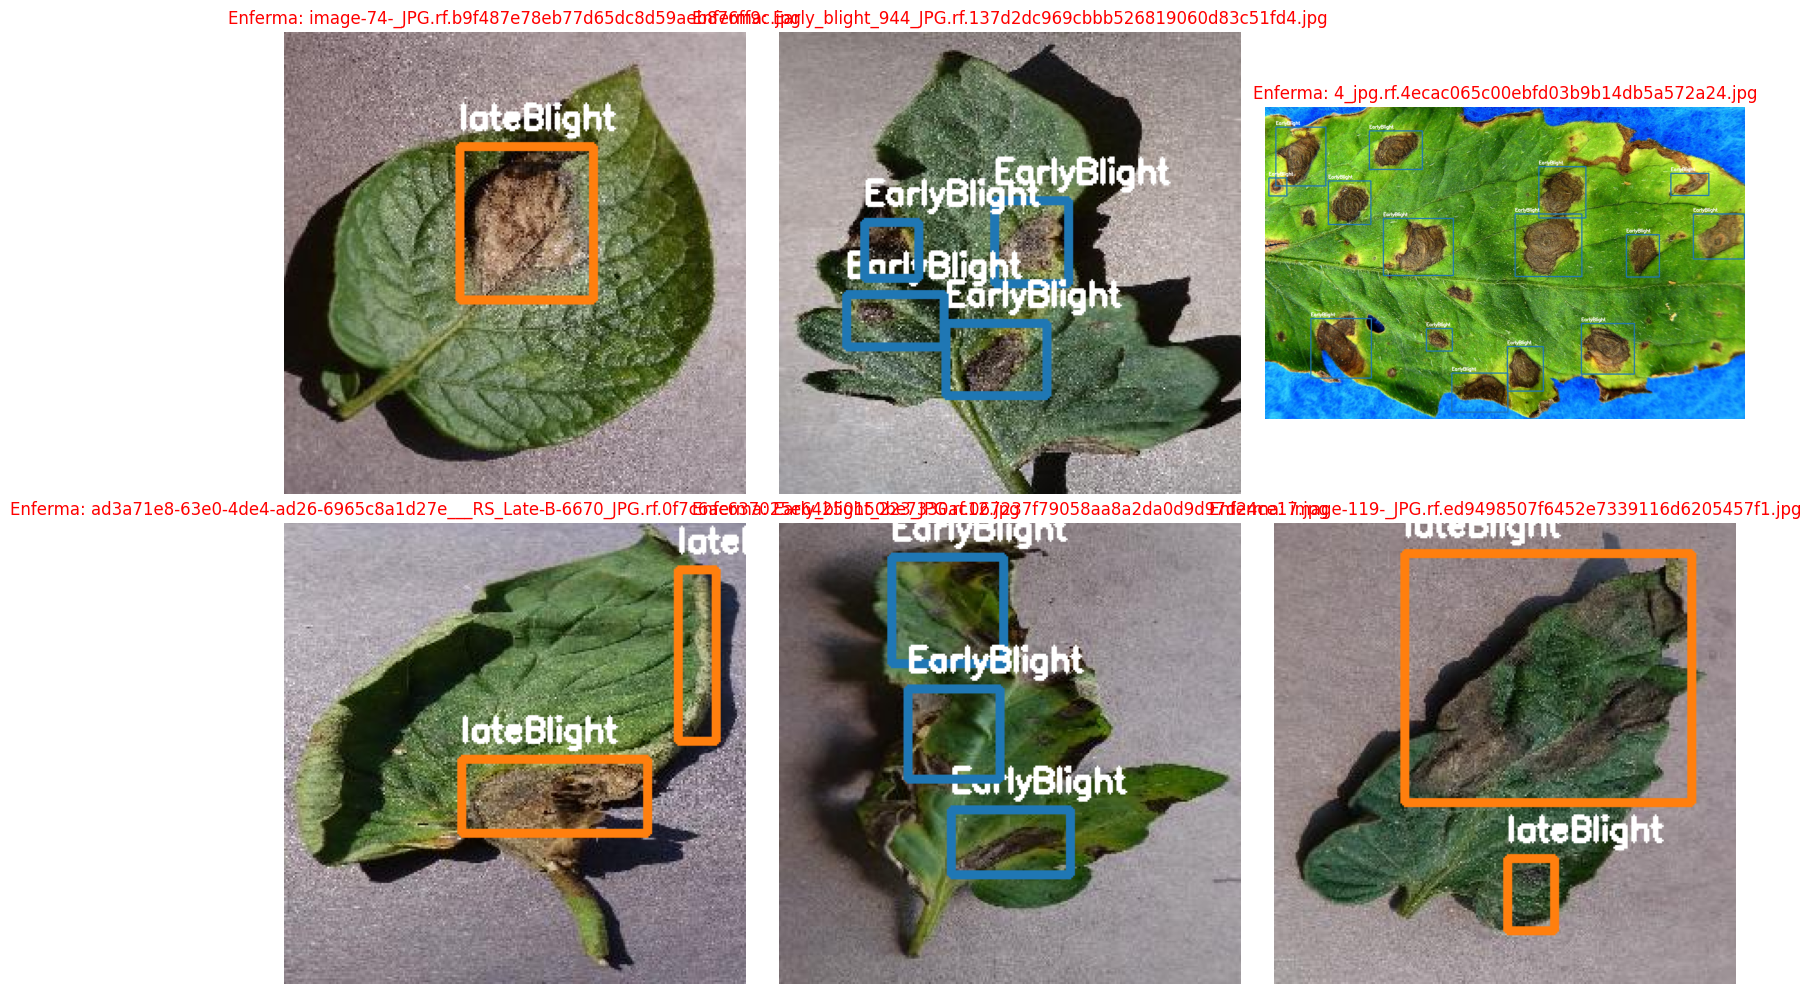

In [ ]:
import os
import glob
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from collections import Counter

print("🤖 VcBot: Verificando dataset modificado...")

# 1. CARGAR CONFIGURACIÓN
if 'dataset_dir' not in locals():
    # Si por alguna razón se perdió la variable, intenta definirla manualmente o busca
    # dataset_dir = "/content/tomatoes-..."
    print("⚠️ Variable dataset_dir no encontrada. Usando ruta actual.")
    dataset_dir = os.getcwd()

yaml_path = os.path.join(dataset_dir, "data.yaml")

with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)
    class_names = data.get('names', [])
    if isinstance(class_names, dict):
        class_names = [class_names[i] for i in sorted(class_names.keys())]

print(f"✅ Nuevas Clases ({len(class_names)}): {class_names}")

# 2. CONTEO DE OBJETOS Y FONDOS
label_files = glob.glob(f'{dataset_dir}/**/labels/*.txt', recursive=True)

class_counts = Counter()
empty_files = 0
total_boxes = 0

for lfile in label_files:
    # Verificamos si el archivo está vacío (0 bytes o sin líneas)
    if os.path.getsize(lfile) == 0:
        empty_files += 1
        continue

    with open(lfile, 'r') as f:
        lines = f.readlines()

    if not lines:
        empty_files += 1
        continue

    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            cls_id = int(parts[0])
            if 0 <= cls_id < len(class_names):
                class_counts[class_names[cls_id]] += 1
                total_boxes += 1

# 3. MOSTRAR RESULTADOS
print("\n📊 REPORTE POST-LIMPIEZA:")
print("-" * 40)
print(f"{'TIPO':<30} | {'CANTIDAD':<10}")
print("-" * 40)
for cls, count in class_counts.most_common():
    print(f"📦 {cls:<28} | {count:<10}")
print("-" * 40)
print(f"🍃 IMÁGENES SANAS (Sin Cajas)   | {empty_files:<10}")
print(f"∑  TOTAL DE CAJAS (Etiquetas)  | {total_boxes:<10}")
print("-" * 40)

# 4. VISUALIZACIÓN DE MUESTRAS
print("\n📸 Mostrando ejemplos (Incluyendo imágenes sanas/vacías)...")

all_images = glob.glob(f'{dataset_dir}/**/images/*.jpg', recursive=True) + \
             glob.glob(f'{dataset_dir}/**/images/*.png', recursive=True)

if all_images:
    # Tomamos una muestra aleatoria
    samples = random.sample(all_images, min(len(all_images), 6))

    plt.figure(figsize=(15, 10))

    for i, img_path in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Buscar label
        label_path = img_path.replace('/images/', '/labels/').rsplit('.', 1)[0] + ".txt"

        box_drawn = False
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls_id = int(parts[0])
                        cx, cy, bw, bh = map(float, parts[1:])

                        x1 = int((cx - bw/2) * w)
                        y1 = int((cy - bh/2) * h)
                        x2 = int((cx + bw/2) * w)
                        y2 = int((cy + bh/2) * h)

                        # Color
                        color = plt.cm.tab10(cls_id % 10)
                        color = (int(color[0]*255), int(color[1]*255), int(color[2]*255))

                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)

                        name = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
                        cv2.putText(img, name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
                        box_drawn = True

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis('off')

        if box_drawn:
            plt.title(f"Enferma: {os.path.basename(img_path)}", color='red')
        else:
            plt.title(f"Sana (Fondo): {os.path.basename(img_path)}", color='green')

    plt.tight_layout()
    plt.show()

#### Ejecucion YOLO

In [ ]:
import gc
import torch
import os
import shutil
import yaml
from ultralytics import YOLO
from google.colab import drive

# ==============================================================================
# 1. PREPARACIÓN Y CONFIGURACIÓN
# ==============================================================================
print("🤖 VcBot: Iniciando configuración...")

# A. Montar Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# B. Definir ruta de salida en Drive (Para los resultados)
DRIVE_OUTPUT = "/content/drive/MyDrive/Torneo_Roboflow_Tomates_No_Healthy"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)


# ==============================================================================
# 2. ENTRENAMIENTO
# ==============================================================================
# Limpieza de memoria
gc.collect()
torch.cuda.empty_cache()

print("🚀 VcBot: Iniciando entrenamiento con YOLOv8-SMALL...")

model = YOLO('yolov8s.pt')

# Nombre del proyecto local
PROYECTO_LOCAL = 'entrenamiento_tomates_no_Healty'
NOMBRE_EJECUCION = 'yolov8s_detect'

try:
    model.train(
        data=f"{dataset_dir}/data.yaml",
        epochs=25,
        imgsz=640,
        batch=16,
        device=0 if torch.cuda.is_available() else 'cpu',
        project=PROYECTO_LOCAL,    # Carpeta raíz local
        name=NOMBRE_EJECUCION,     # Subcarpeta local
        patience=10,
        plots=True                 # ¡Importante! Genera los gráficos
    )
    print("✅ Entrenamiento finalizado correctamente.")

    # ==============================================================================
    # 3. GUARDAR SOLO RESULTADOS (SIN MODELOS PESADOS)
    # ==============================================================================
    print("\n📦 Empaquetando y guardando resultados en Drive...")

    # Ruta donde YOLO guardó todo en Colab
    origen_resultados = f"/content/{PROYECTO_LOCAL}/{NOMBRE_EJECUCION}"

    # Ruta destino en Drive
    destino_resultados = f"{DRIVE_OUTPUT}/{NOMBRE_EJECUCION}_Resultados"

    # Si ya existe la carpeta en Drive, la borramos para actualizarla
    if os.path.exists(destino_resultados):
        shutil.rmtree(destino_resultados)

    # COPIAR TODO EXCEPTO LA CARPETA 'weights'
    # Esto copiará: results.csv, confusion_matrix.png, results.png, etc.
    shutil.copytree(
        origen_resultados,
        destino_resultados,
        ignore=shutil.ignore_patterns('weights', '*.pt') # <--- AQUÍ ESTÁ LA MAGIA
    )

    print(f"🎉 ¡ÉXITO! Resultados guardados en: {destino_resultados}")
    print("   (Se han excluido los archivos .pt para ahorrar espacio, solo tienes gráficas y tablas)")

except Exception as e:
    print(f"❌ Error: {e}")!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="optsSQIAxiNXEdI8izmp")
project = rf.workspace("germanrv").project("potatoes_leaf-diseases")
version = project.version(1)
dataset = version.download("yolov8")


🤖 VcBot: Iniciando configuración...
🚀 VcBot: Iniciando entrenamiento con YOLOv8-SMALL...
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/tomatoes-7/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_detect, nbs=64, nms=False, ops

In [ ]:
import gc
import torch
import os
import shutil
import yaml
from ultralytics import YOLO
from google.colab import drive

# ==============================================================================
# 1. CONFIGURACIÓN DEL TORNEO
# ==============================================================================
print("🤖 VcBot: Preparando el cuadrilátero para el torneo...")

# A. Montar Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# B. Ruta base del torneo en Drive
DRIVE_BASE = "/content/drive/MyDrive/Torneo_YOLO_Tomates"
os.makedirs(DRIVE_BASE, exist_ok=True)

# C. Definir los contendientes (Modelos)
# Ajustamos el batch size: 'l' (large) consume mucha VRAM, así que bajamos a 8 o 4.
contendientes = [
    {"nombre": "yolov8s.pt",  "batch": 16},
    {"nombre": "yolov8m.pt",  "batch": 16},
    {"nombre": "yolov8l.pt",  "batch": 8},  # Batch reducido por seguridad
    {"nombre": "yolo11s.pt",  "batch": 16},
    {"nombre": "yolo11m.pt",  "batch": 16},
    {"nombre": "yolo11l.pt",  "batch": 8}   # Batch reducido por seguridad
]

# D. Asegurar data.yaml (usando tu variable dataset_dir)
# Asumimos que dataset_dir ya está definido por tu bloque de descarga anterior
if 'dataset_dir' in locals():
    yaml_path = f"{dataset_dir}/data.yaml"
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    data['path'] = os.path.abspath(dataset_dir)
    data['train'] = "train/images"
    data['val'] = "valid/images"
    data['test'] = "test/images"
    with open(yaml_path, 'w') as f:
        yaml.dump(data, f)
else:
    print("⚠️ ADVERTENCIA: Variable 'dataset_dir' no encontrada. Verifica la descarga.")

# ==============================================================================
# 2. BUCLE DE COMBATE (ENTRENAMIENTO)
# ==============================================================================

for i, luchador in enumerate(contendientes):
    modelo_archivo = luchador["nombre"]
    batch_size = luchador["batch"]
    nombre_combate = modelo_archivo.replace('.pt', '') # Ejemplo: yolov8s

    print("\n" + "="*60)
    print(f"🥊 RONDA {i+1}/{len(contendientes)}: Entrenando {nombre_combate} (Batch: {batch_size})")
    print("="*60)

    # 1. Limpieza de memoria (Fundamental en Colab)
    gc.collect()
    torch.cuda.empty_cache()

    try:
        # 2. Cargar modelo
        print(f"   ⏳ Cargando pesos: {modelo_archivo}...")
        model = YOLO(modelo_archivo)

        # 3. Entrenar
        # Usamos el mismo 'project' para que sea fácil comparar luego
        model.train(
            data=f"{dataset_dir}/data.yaml",
            epochs=25,                  # 25 épocas para el torneo
            imgsz=640,
            batch=batch_size,
            device=0 if torch.cuda.is_available() else 'cpu',
            project='Torneo_Local',     # Carpeta raíz en Colab
            name=nombre_combate,        # Subcarpeta (ej: yolov8s)
            patience=10,
            plots=True,
            verbose=True
        )
        print(f"   ✅ {nombre_combate} terminó el entrenamiento.")

        # 4. Guardar resultados en Drive
        print(f"   📦 Guardando estadísticas en Drive...")

        origen = f"/content/Torneo_Local/{nombre_combate}"
        destino = f"{DRIVE_BASE}/{nombre_combate}"

        if os.path.exists(destino):
            shutil.rmtree(destino)

        # Copiamos todo MENOS los pesos (.pt) para ahorrar espacio y tiempo
        # Si quieres guardar el mejor modelo, quita 'best.pt' de ignore_patterns
        shutil.copytree(
            origen,
            destino,
            ignore=shutil.ignore_patterns('weights', 'last.pt')
            # Nota: Si quieres guardar el modelo entrenado, borra 'weights' de arriba
        )
        print(f"   🎉 Resultados de {nombre_combate} guardados.")

    except Exception as e:
        print(f"   ❌ KO TÉCNICO: Error entrenando {nombre_combate}: {e}")
        # Intentamos seguir con el siguiente modelo aunque este falle
        continue

print("\n" + "="*60)
print("🏆 ¡TORNEO FINALIZADO!")
print(f"📂 Revisa los resultados y gráficas en Drive: {DRIVE_BASE}")
print("="*60)

🤖 VcBot: Preparando el cuadrilátero para el torneo...

🥊 RONDA 1/6: Entrenando yolov8s (Batch: 16)
   ⏳ Cargando pesos: yolov8s.pt...
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/tomatoes-7/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False